In [51]:
!pip install -q tensorflow-recommenders
#!pip install tensorflow-gpu
# !pip install tensorflow-recommenders-addons-gpu

# Import the required library

In [52]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
# import tensorflow_recommenders_addons as tfra
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [53]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('No GPU available.')

Default GPU Device: /device:GPU:0


In [54]:
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45558 entries, 0 to 46627
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45558 non-null  object 
 1   budget                45558 non-null  object 
 2   genres                45558 non-null  object 
 3   id                    45558 non-null  int64  
 4   original_language     45558 non-null  object 
 5   original_title        45558 non-null  object 
 6   overview              45558 non-null  object 
 7   popularity            45558 non-null  object 
 8   production_companies  45558 non-null  object 
 9   production_countries  45558 non-null  object 
 10  release_date          45558 non-null  object 
 11  revenue               45558 non-null  float64
 12  runtime               45558 non-null  float64
 13  spoken_languages      45558 non-null  object 
 14  tagline               45558 non-null  object 
 15  vote_average          45

# Preprocessing the data

In [56]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [57]:
##preprocessing
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

In [58]:
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

In [59]:
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [60]:
df.head()
#df.to_csv('all_data.csv', index=False)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42373 non-null  object        
 1   budget                42373 non-null  float64       
 2   genres                42373 non-null  object        
 3   id                    42373 non-null  int64         
 4   original_language     42373 non-null  object        
 5   original_title        42373 non-null  object        
 6   overview              42373 non-null  object        
 7   popularity            42373 non-null  float64       
 8   production_companies  42373 non-null  object        
 9   production_countries  42373 non-null  object        
 10  release_date          42373 non-null  datetime64[ns]
 11  revenue               42373 non-null  float64       
 12  runtime               42373 non-null  float64       
 13  spoken_languages

<h1 style="font-family: Trebuchet MS; font-size: 27px; color: #3a5a40; text-align: left; "><b>Visualization of data</b></h1>

(0.0, 2.0, 0.9, 1.2)

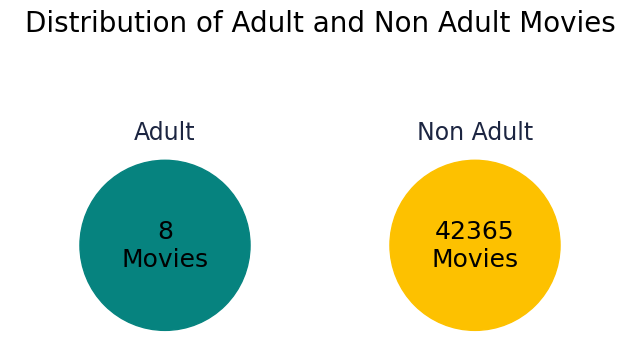

In [62]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies',fontsize=20)
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18,)
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18)
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

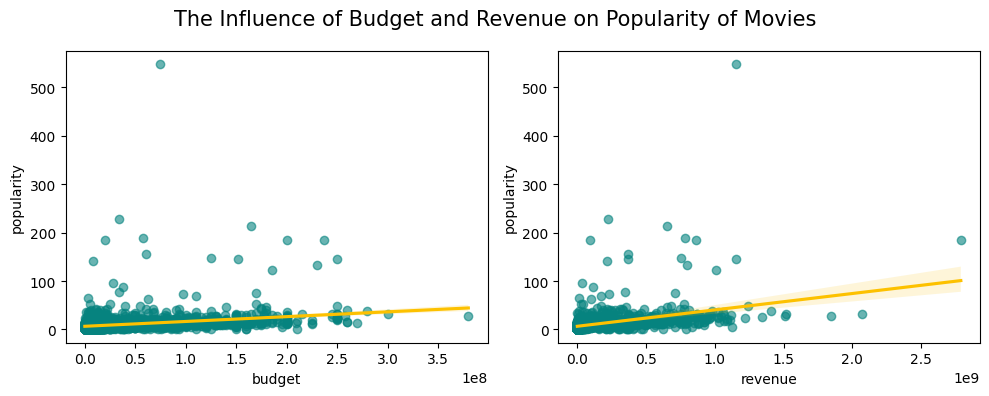

In [63]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]
# df_plot.head()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue on Popularity of Movies', fontsize=15)
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

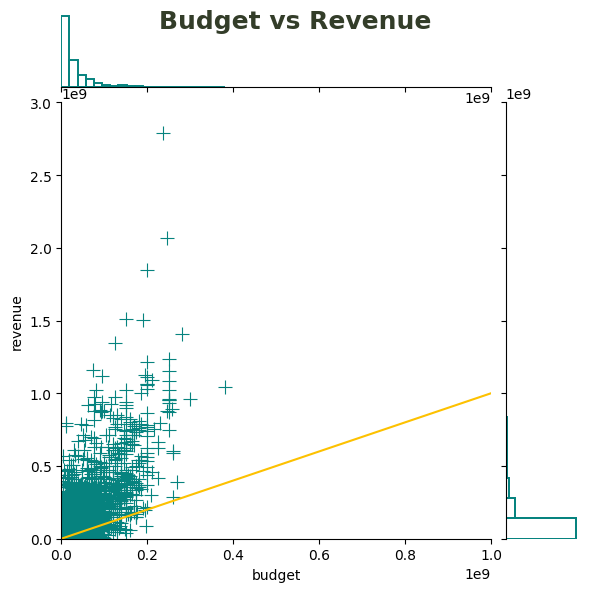

In [64]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

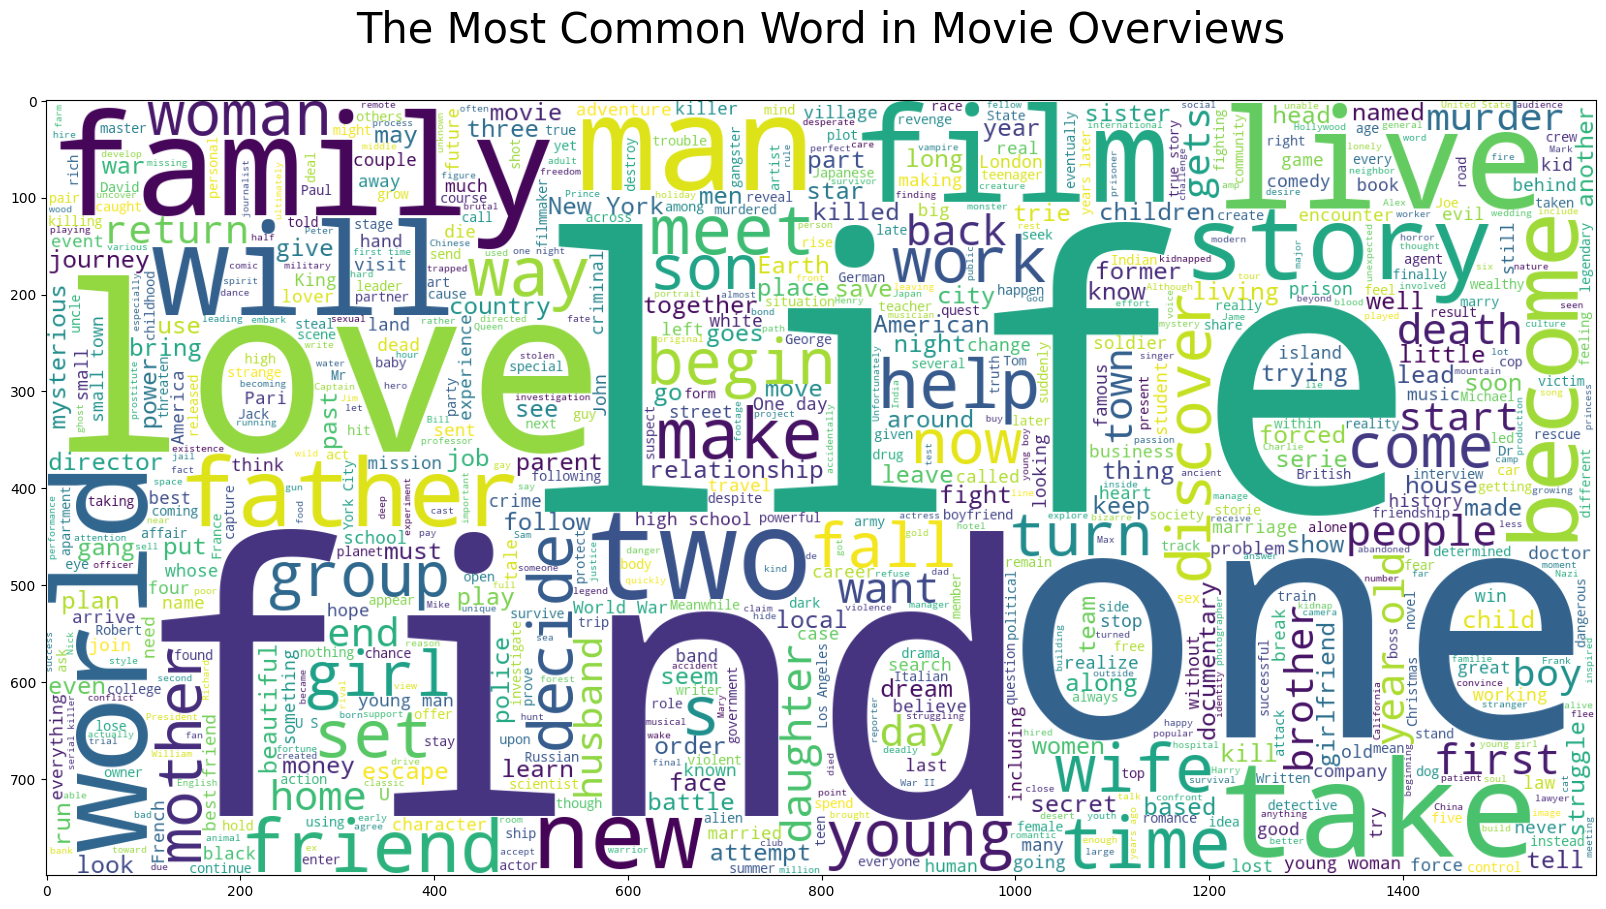

In [65]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30)
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

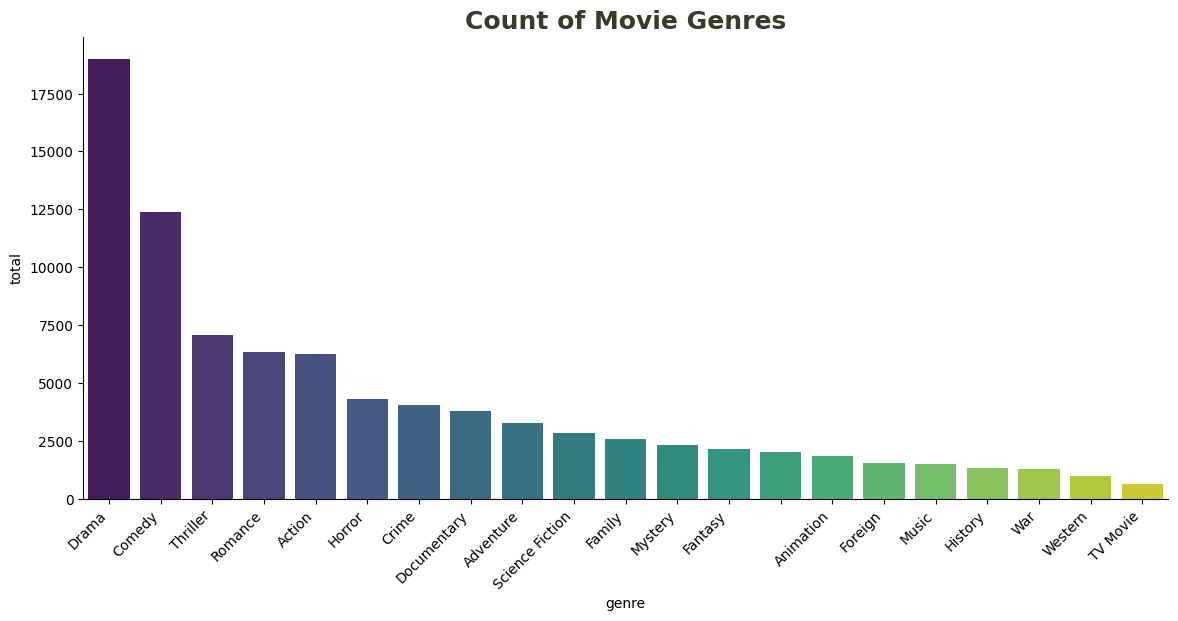

(-1.25, 1.25, -1.25, 1.25)

In [66]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))
    
#print(genres_list)

fig, ax = plt.subplots(figsize=(14, 6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', palette='viridis')
ax.set_title('Count of Movie Genres', fontsize=18, weight='bold', color='#333d29')
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
# ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
# ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
# sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
#plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

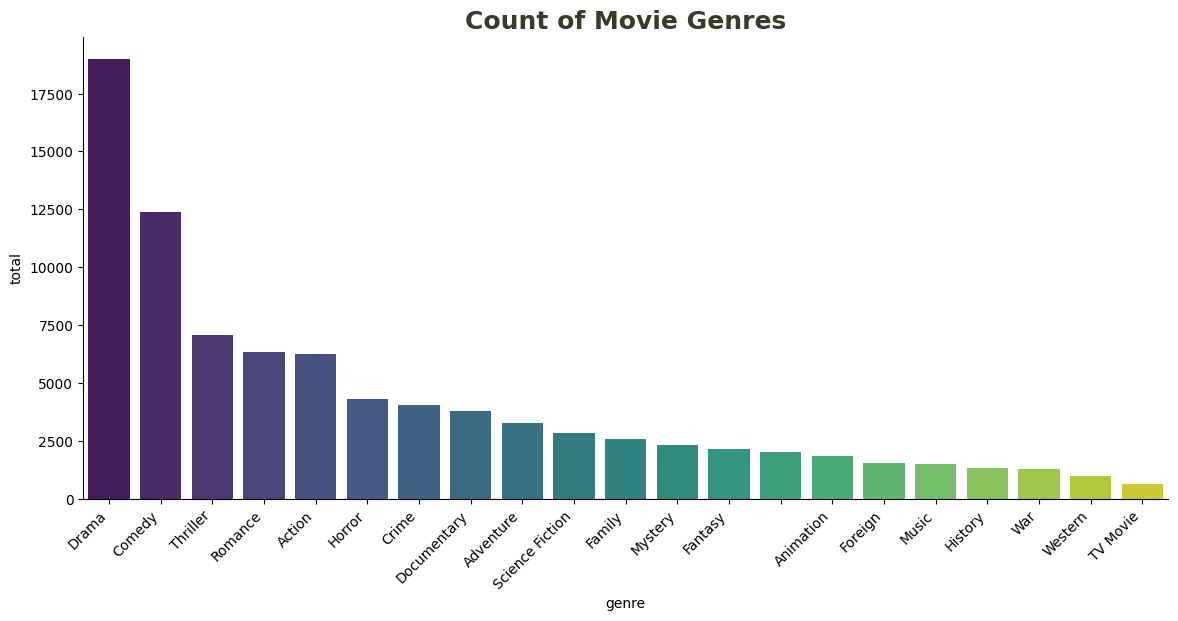

In [67]:
fig, ax = plt.subplots(figsize=(14, 6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', palette='viridis')
ax.set_title('Count of Movie Genres', fontsize=18, weight='bold', color='#333d29')
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

Text(0.5, 1.0, 'Total Released Movie by Date')

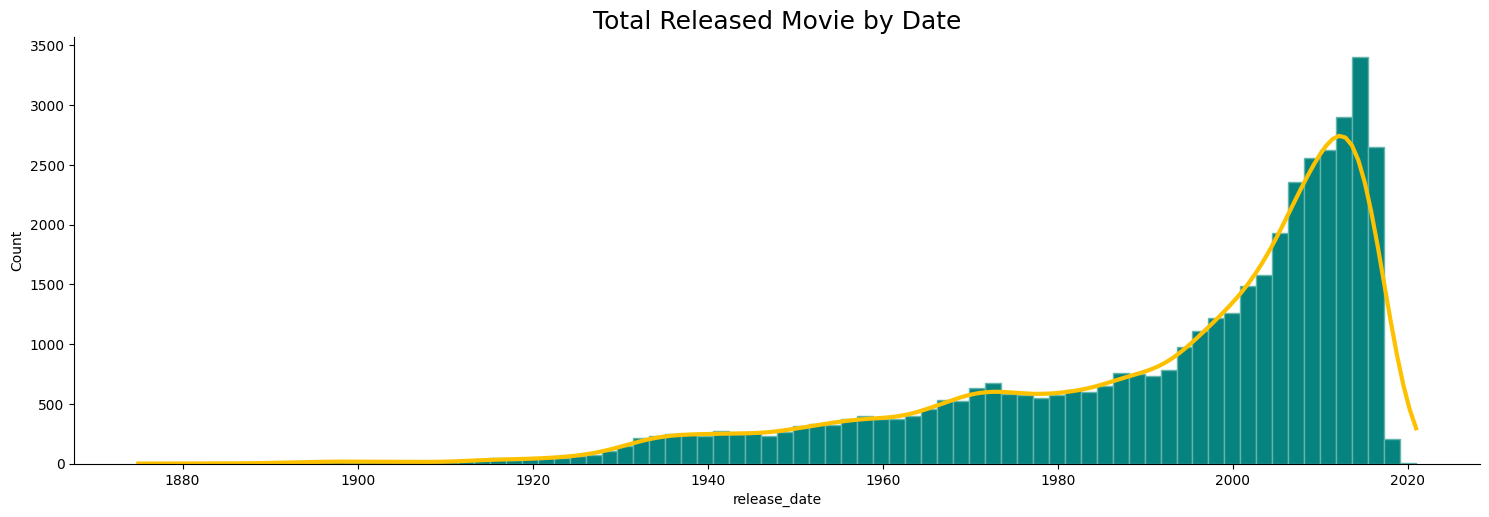

In [68]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18)

In [69]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

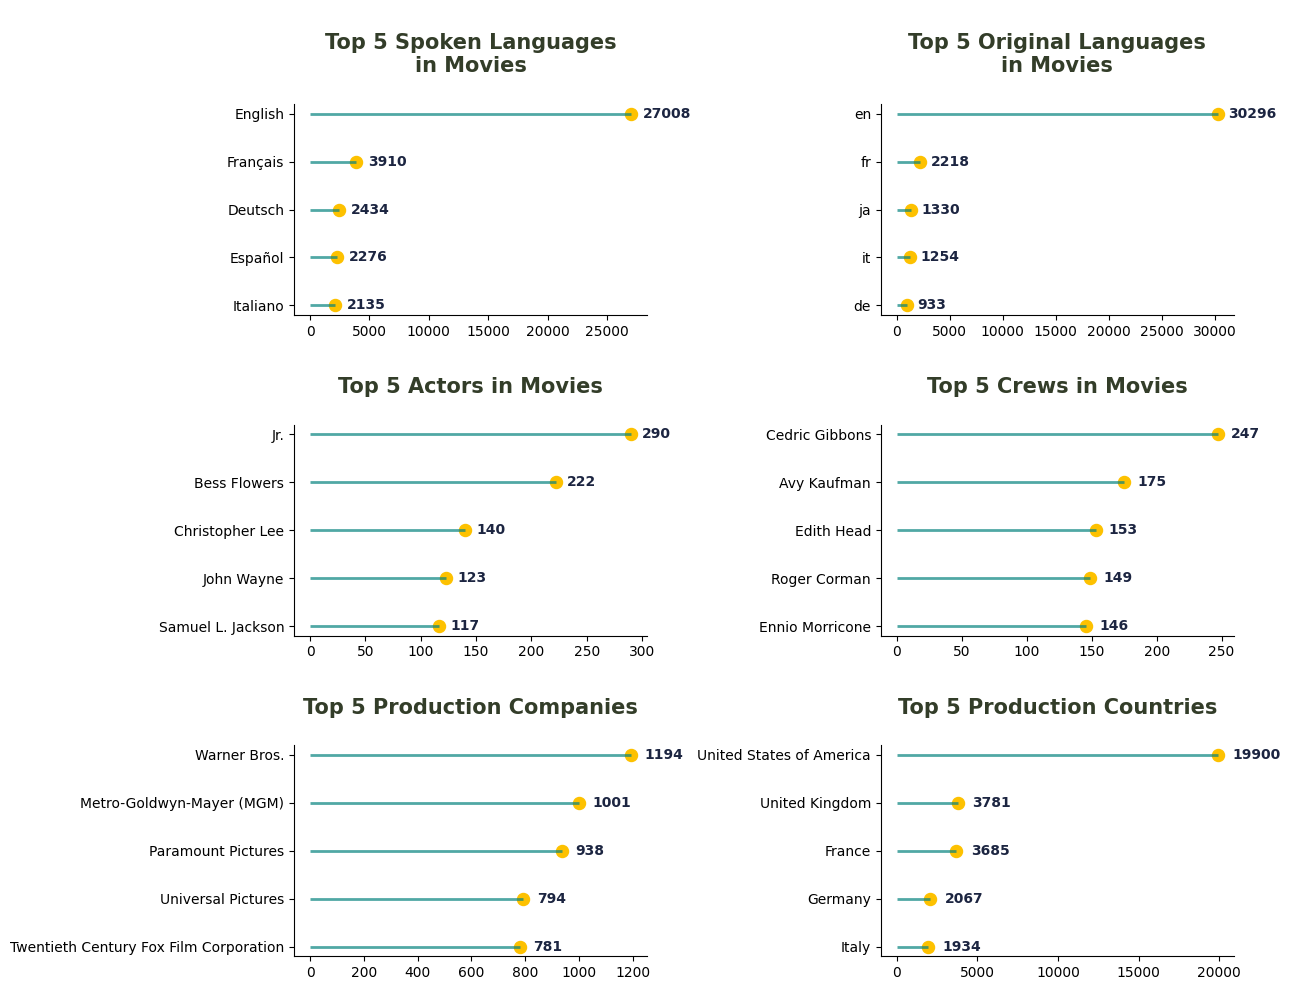

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

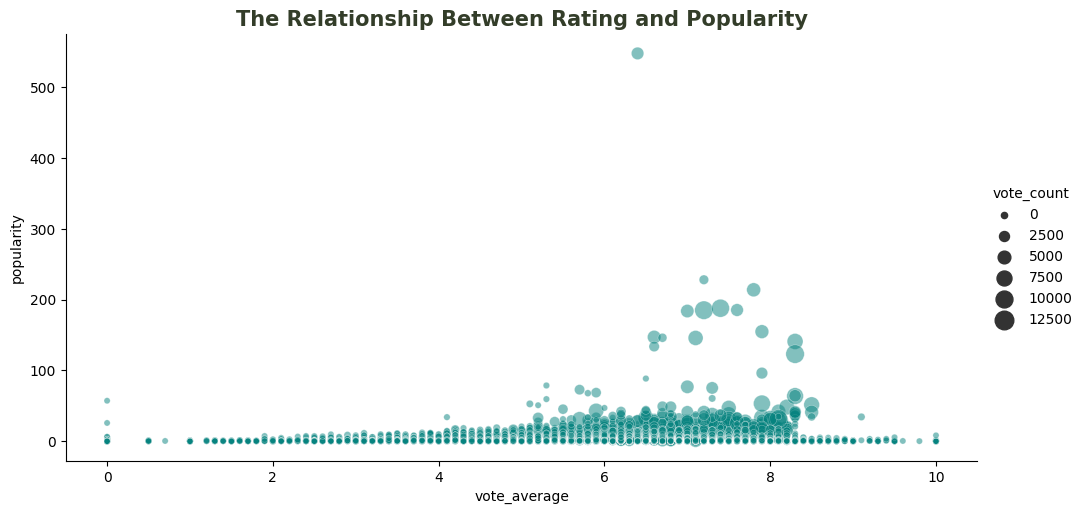

In [71]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

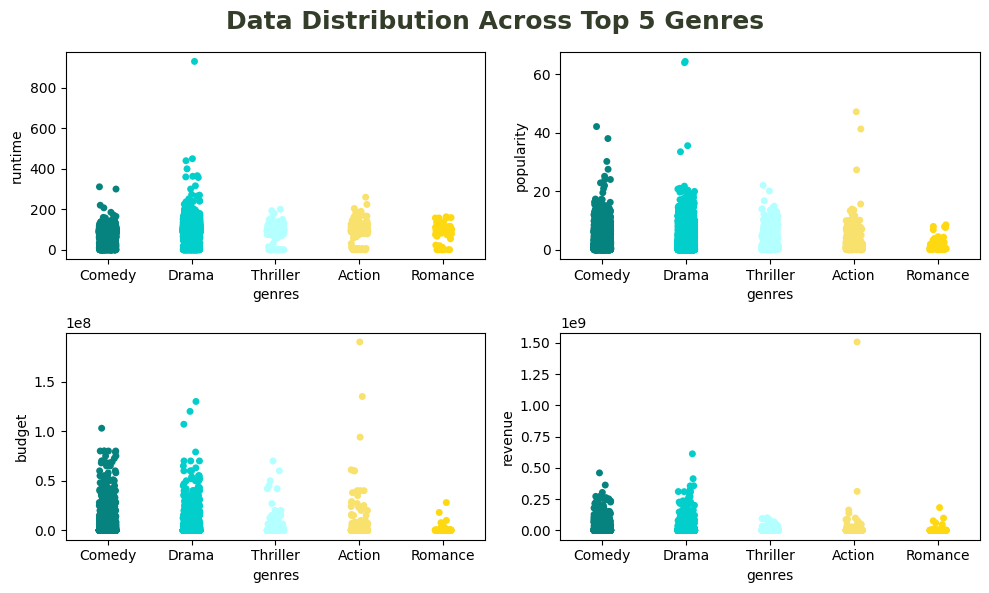

In [72]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

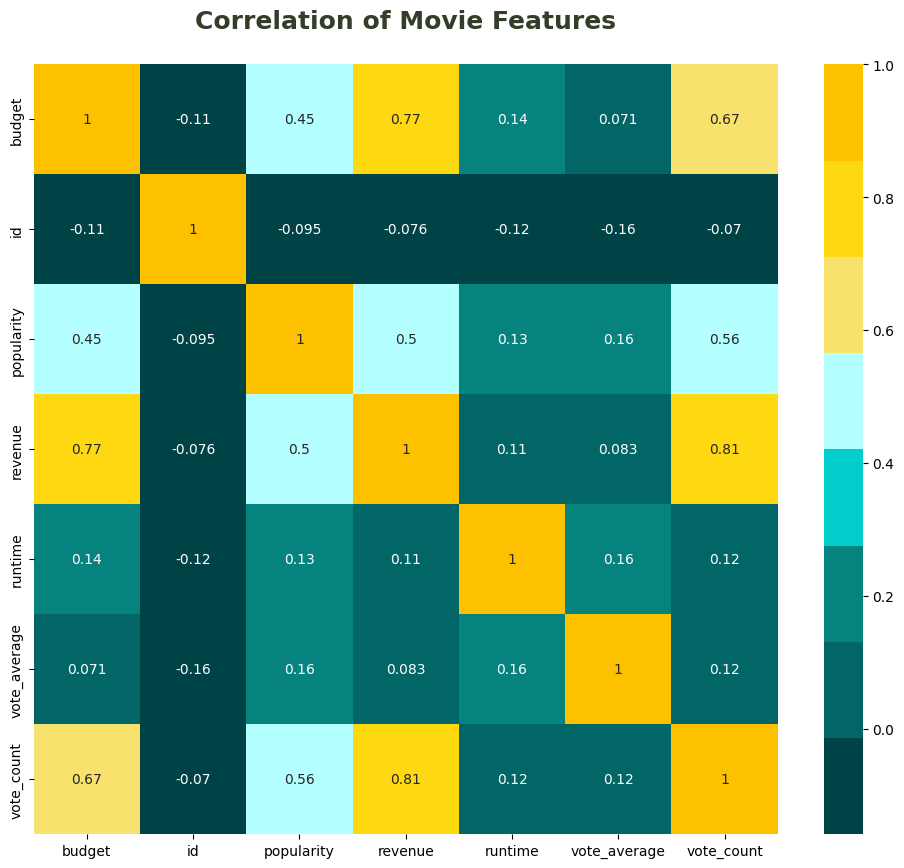

In [73]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight='bold', color='#333d29')

# Calculate the correlation matrix for the numeric columns
corr_matrix = numeric_df.corr()

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

plt.show()

In [74]:
df.to_csv("save.csv",index=False)

# Engine

In [75]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()
df['weighted_average'] = (R*v + C*m)/(v+m)

In [76]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [77]:
weighted_df.head()

,popularity,weighted_average
original_title,,
Toy Story,0.040087,0.811158
Jumanji,0.031079,0.681205
Grumpier Old Men,0.021394,0.572328
Waiting to Exhale,0.007049,0.513395
Father of the Bride Part II,0.015320,0.490369


In [78]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [79]:
hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]
hybrid_df.head(5)

,original_title,adult,genres,overview,production_companies,tagline,keywords,crew,characters,actors
0,Toy Story,False,"Animation, Comedy, Family","Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,Jumanji,False,"Adventure, Fantasy, Family",When siblings Judy and Peter discover an encha...,"TriStar Pictures, Teitler Film, Interscope Com...",Roll the dice and unleash the excitement!,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,Grumpier Old Men,False,"Romance, Comedy",A family wedding reignites the ancient feud be...,"Warner Bros., Lancaster Gate",Still Yelling. Still Fighting. Still Ready for...,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,Waiting to Exhale,False,"Comedy, Drama, Romance","Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,Friends are the people who let you be yourself...,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,Father of the Bride Part II,False,Comedy,Just when George Banks has recovered from his ...,"Sandollar Productions, Touchstone Pictures",Just When His World Is Back To Normal... He's ...,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [80]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [81]:
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)
hybrid_df.head()

,original_title,adult,genres,overview,production_companies,tagline,keywords,crew,characters,actors
0,Toy Story,false,animation comedy family,led by woody andys toys live happily in his ro...,pixaranimationstudios,,jealousy toy boy friendship friends rivalry bo...,johnlasseter josswhedon andrewstanton joelcohe...,woody buzzlightyear mrpotatohead slinkydog rex...,tomhanks timallen donrickles jimvarney wallace...
1,Jumanji,false,adventure fantasy family,when siblings judy and peter discover an encha...,tristarpictures teitlerfilm interscopecommunic...,roll the dice and unleash the excitement,boardgame disappearance basedonchildrensbook n...,larryjfranco jonathanhensleigh jameshorner joe...,alanparrish samuelalanparrishvanpelt judyshepe...,robinwilliams jonathanhyde kirstendunst bradle...
2,Grumpier Old Men,false,romance comedy,a family wedding reignites the ancient feud be...,warnerbros lancastergate,still yelling still fighting still ready for love,fishing bestfriend duringcreditsstinger oldmen,howarddeutch markstevenjohnson markstevenjohns...,maxgoldman johngustafson arielgustafson marias...,waltermatthau jacklemmon annmargret sophialore...
3,Waiting to Exhale,false,comedy drama romance,cheated on mistreated and stepped on the women...,twentiethcenturyfoxfilmcorporation,friends are the people who let you be yourself...,basedonnovel interracialrelationship singlemot...,forestwhitaker ronaldbass ronaldbass ezraswerd...,savannahvannahjackson bernadinebernieharris gl...,whitneyhouston angelabassett lorettadevine lel...
4,Father of the Bride Part II,false,comedy,just when george banks has recovered from his ...,sandollarproductions touchstonepictures,just when his world is back to normal hes in f...,baby midlifecrisis confidence aging daughter m...,alansilvestri elliotdavis nancymeyers nancymey...,georgebanks ninabanks franckeggelhoffer annieb...,stevemartin dianekeaton martinshort kimberlywi...


In [82]:
hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [83]:
hybrid_df = weighted_df_sorted.merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=25)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(42373, 12579)

In [84]:
hybrid_df.head(10)

,popularity,weighted_average,score,bag_of_words
original_title,,,,
Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...
Deadpool,0.343132,0.764657,0.511742,false action adventure comedy deadpool tells t...
Gone Girl,0.282748,0.843413,0.507014,false mystery thriller drama with his wifes di...
The Dark Knight,0.224968,0.909123,0.498630,false drama action crime thriller batman raise...
Avatar,0.338036,0.732643,0.495879,false action adventure fantasy science fiction...


In [85]:
# cos_sim = cosine_similarity(tfidf_matrix)
#cos_sim.shape

In [86]:
hybrid_df.reset_index()

,original_title,popularity,weighted_average,score,bag_of_words
0,Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
1,Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
2,Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
3,Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
4,Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...
...,...,...,...,...,...
42368,Birdemic: Shock and Terror,0.004621,0.155452,0.064953,false horror science fiction a platoon of eagl...
42369,Epic Movie,0.010136,0.141691,0.062758,false action adventure comedy when edward pete...
42370,Battlefield Earth,0.009638,0.127443,0.056760,false action science fiction war in the year ...
42371,Dragonball Evolution,0.016213,0.084011,0.043332,false action adventure fantasy science fiction...


In [90]:
from sklearn.metrics.pairwise import cosine_similarity

# Define the number of partitions and their size
num_partitions = 10
num_rows, num_features = tfidf_matrix.shape
partition_size = num_rows // num_partitions

# Initialize an empty list to store the results
all_cos_sim = []

# Calculate cosine similarity in partitions
for i in range(num_partitions):
    start = i * partition_size
    end = (i + 1) * partition_size
    partition_cos_sim = cosine_similarity(tfidf_matrix[start:end])
    all_cos_sim.append(partition_cos_sim)

# Combine results (assuming you want a single cosine similarity matrix)
cos_sim = np.vstack(all_cos_sim)

In [91]:
cos_sim.shape

(42370, 4237)

In [92]:
#hybrid_df.reset_index()

In [93]:
def predict(title, similarity_weight, top_n):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [94]:
predict('Jumanji', similarity_weight=0.7, top_n=5)

,score,similarity,final_score
original_title,,,
Jumanji,0.291130,1.000000,0.787339
Minions,0.841413,0.013468,0.261851
Big Hero 6,0.565386,0.008973,0.175897
Guardians of the Galaxy Vol. 2,0.521054,0.027106,0.175290
Baby Driver,0.540998,0.014348,0.172343


In [95]:
import pickle
pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

<a id=4 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Deep Learning</b></h1>

Official documentation: https://www.tensorflow.org/recommenders

Tensorflow comes with a library called TensorFlow Recommenders (TFRS) for building a recommender system. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

This time, we use multi-objective approach that applies both implicit (movie watches) and explicit signals (ratings). In the end, we can predict what movies should the user watch along with the given rating corresponds to historical data

In [96]:
ratings_df = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [97]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43188 entries, 0 to 43187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   userId          43188 non-null  int64         
 1   movieId         43188 non-null  int64         
 2   rating          43188 non-null  float64       
 3   date            43188 non-null  datetime64[ns]
 4   original_title  43188 non-null  object        
 5   genres          43188 non-null  object        
 6   overview        43188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.3+ MB


In [98]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [99]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [100]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(40000)
test = ratings.skip(40000).take(969295)
print('Total Data: {}'.format(len(train)))
print('Total Data: {}'.format(len(test)))

Total Data: 43188
Total Data: 40000
Total Data: 3188


In [101]:
movie_titles = movies.batch(3_000)
user_ids = ratings.batch(3_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [102]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
#     tf.config.experimental.set_memory_growth('GPU', True)

    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [103]:
# model = tfrs.models.RetrievalModel(device='GPU')

model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(10_0000).batch(1_0000).cache()
cached_test = test.batch(1_000).cache()
with tf.device('GPU'):
    model.fit(cached_train, epochs=10)
model.fit(cached_train, epochs=10)

Epoch 1/10
4/4 [==============================] - 55s 13s/step - root_mean_squared_error: 2.6736 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_10_categorical_accuracy: 7.2500e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0162 - factorized_top_k/top_100_categorical_accuracy: 0.0464 - loss: 91965.9484 - regularization_loss: 0.0000e+00 - total_loss: 91965.9484
Epoch 2/10
4/4 [==============================] - 49s 12s/step - root_mean_squared_error: 1.7060 - factorized_top_k/top_1_categorical_accuracy: 7.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0069 - factorized_top_k/top_10_categorical_accuracy: 0.0168 - factorized_top_k/top_50_categorical_accuracy: 0.1315 - factorized_top_k/top_100_categorical_accuracy: 0.2471 - loss: 88976.9266 - regularization_loss: 0.0000e+00 - total_loss: 88976.9266
Epoch 3/10
4/4 [==============================] - 49s 12s/step - root_mean_squared_err

In [104]:
model.save_weights('tfrs.h5')

In [105]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [106]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. Jezebel
2. La révolution française
3. Kurz und schmerzlos
4. The Wanderers
5. Un long dimanche de fiançailles


In [107]:
predict_rating(123,'Minions')

Predicted rating for Minions: 2.8821842670440674


In [108]:
ratings_df[ratings_df['userId'] == '123']

,userId,movieId,rating,date,original_title,genres,overview
8053,123,233,4.0,2001-07-01 20:57:06,The Wanderers,Drama,The streets of the Bronx are owned by 60’s you...
8054,123,288,5.0,2001-07-01 19:32:47,High Noon,Western,High Noon is about a recently freed leader of ...
8055,123,407,5.0,2001-07-01 20:57:57,Kurz und schmerzlos,"Drama, Thriller",Three friends get caught in a life of major cr...
8056,123,968,3.0,2001-07-01 20:59:01,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...
8057,123,1968,4.0,2001-07-01 19:30:36,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
8058,123,1976,4.0,2001-07-01 19:31:51,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."
8059,123,2003,4.0,2001-07-01 19:31:51,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
8060,123,2428,5.0,2001-07-01 20:57:06,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
8061,123,2502,5.0,2001-07-01 20:59:01,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
8062,123,2762,5.0,2001-07-01 20:59:54,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...
